In [663]:
from tensorflow import keras
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd
import os

In [664]:
file_list = os.listdir('./results/')
n_res = len(file_list)

In [665]:
nn_input_list = []
nn_output_list = []
for file_i in file_list:
    res = do_mpc.data.load_results('./results/'+file_i)

    phi = res['simulator']['_x', 'phi'].flatten()
    theta = res['simulator']['_x', 'theta'].flatten()
    u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
    psi = res['simulator']['_x', 'psi'].flatten()
    E_0 = res['simulator']['_p', 'E_0'].flatten()
    v_0 = res['simulator']['_p', 'v_0'].flatten()
        
    phi = np.roll(phi, -1)
    theta = np.roll(theta, -1)
    psi = np.roll(psi, -1)
        
    phi = phi[:-1]
    theta = theta[:-1]
    u_tilde = u_tilde[:-1]
    psi = psi[:-1]
    E_0 = E_0[:-1]
    v_0 = v_0[:-1]
    
    # Normal distribution with random sigma between 0 and 0.1
    phi_dist = phi+0.01*np.random.randn(phi.shape[0])
    theta_dist = theta+0.01*np.random.randn(theta.shape[0])

    nn_input = {'phi':phi_dist, 'theta': theta_dist, 'u_tilde': u_tilde}
    nn_output = {'phi':phi, 'theta': theta, 'psi': psi, 'u_tilde': u_tilde, 'E_0': E_0, 'v_0': v_0}

    nn_input_df = pd.DataFrame.from_dict(nn_input)
    nn_output_df = pd.DataFrame.from_dict(nn_output)

    nn_input_list.append(nn_input_df)
    nn_output_list.append(nn_output_df)

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [666]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = model_selection.train_test_split(nn_input_list, nn_output_list)

In [667]:
y_scaling = pd.concat(nn_output_train).abs().max().to_numpy()
x_scaling = pd.concat(nn_input_train).abs().max().to_numpy()

In [668]:
y_scaling

array([ 1.33485828,  1.39634052,  3.1460901 , 10.        ,  8.41068296,
       18.07555251])

In [669]:
n_datasets = len(nn_input_train)
seq_length = 20  # length of sequence for ANN training

n_data = nn_input_train[0].shape[0]
n_seq = (n_data // seq_length) - 1

# create sequences from the data:
X = []
Y = []
# for data_i in range(n_datasets):
#     X_train = nn_input_train[data_i].to_numpy()
#     Y_train = nn_output_train[data_i].to_numpy()
#     for offset in range(seq_length):
#         for data_sample in range(n_seq-1):
#             start_ind = data_sample*seq_length+offset
#             X.append(X_train[start_ind:start_ind + seq_length, :])
#             Y.append(Y_train[start_ind:start_ind + seq_length, :])

for data_sample in range(n_seq):
    for data_i in range(n_datasets):
        X_train = nn_input_train[data_i].to_numpy()
        Y_train = nn_output_train[data_i].to_numpy()
        for offset in range(seq_length):
            start_ind = data_sample*seq_length+offset
            X.append(X_train[start_ind:start_ind + seq_length, :]/x_scaling)
            Y.append(Y_train[start_ind:start_ind + seq_length, :]/y_scaling)

X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

batch_size = seq_length*n_datasets
nx = X.shape[2]
ny = Y.shape[2]

In [670]:
batch_size

640

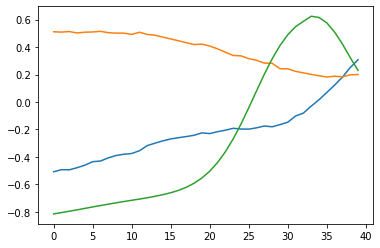

In [671]:
n= 15
plt.plot(np.concatenate((X[0+n],X[batch_size+n])))

We obtain the following training data shape:

In [672]:
X.shape

(21120, 20, 3)

Note that with the batch_size:

In [673]:
batch_size

640

WE obtain

In [674]:
X.shape[0]/batch_size

33.0

consecutive sequences for each batch.

# Create RNN:

In [675]:
stateful = True
n_layer = 3  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [30]
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 30
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (640, 20, 30)             4080      
_________________________________________________________________
time_distributed_211 (TimeDi (640, 20, 30)             930       
_________________________________________________________________
time_distributed_212 (TimeDi (640, 20, 30)             930       
_________________________________________________________________
time_distributed_213 (TimeDi (640, 20, 30)             930       
_________________________________________________________________
time_distributed_214 (TimeDi (640, 20, 6)              186       
Total params: 7,056
Trainable params: 7,056
Non-trainable params: 0
_________________________________________________________________


In [676]:
cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())

history = model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=500, verbose=1, shuffle=False)

Train on 21120 samples
Epoch 1/500
21120/21120 [==============================] - 2s 103us/sample - loss: 0.1299
Epoch 2/500
21120/21120 [==============================] - 1s 51us/sample - loss: 0.0430
Epoch 3/500
21120/21120 [==============================] - 1s 51us/sample - loss: 0.0230
Epoch 4/500
21120/21120 [==============================] - 1s 53us/sample - loss: 0.0170
Epoch 5/500
21120/21120 [==============================] - 1s 71us/sample - loss: 0.0157
Epoch 6/500
21120/21120 [==============================] - 1s 53us/sample - loss: 0.0148
Epoch 7/500
21120/21120 [==============================] - 1s 54us/sample - loss: 0.0140
Epoch 8/500
21120/21120 [==============================] - 1s 55us/sample - loss: 0.0134
Epoch 9/500
21120/21120 [==============================] - 1s 53us/sample - loss: 0.0129
Epoch 10/500
21120/21120 [==============================] - 1s 55us/sample - loss: 0.0125
Epoch 11/500
21120/21120 [==============================] - 1s 55us/sample - loss: 0.

21120/21120 [==============================] - 1s 54us/sample - loss: 0.0063
Epoch 92/500
21120/21120 [==============================] - 1s 63us/sample - loss: 0.0060
Epoch 93/500
21120/21120 [==============================] - 1s 66us/sample - loss: 0.0054
Epoch 94/500
21120/21120 [==============================] - 1s 68us/sample - loss: 0.0047
Epoch 95/500
21120/21120 [==============================] - 1s 53us/sample - loss: 0.0049
Epoch 96/500
21120/21120 [==============================] - 1s 60us/sample - loss: 0.0050
Epoch 97/500
21120/21120 [==============================] - 1s 55us/sample - loss: 0.0047
Epoch 98/500
21120/21120 [==============================] - 1s 54us/sample - loss: 0.0041
Epoch 99/500
21120/21120 [==============================] - 1s 62us/sample - loss: 0.0044
Epoch 100/500
21120/21120 [==============================] - 1s 53us/sample - loss: 0.0049
Epoch 101/500
21120/21120 [==============================] - 1s 51us/sample - loss: 0.0047
Epoch 102/500
21120/2

21120/21120 [==============================] - 1s 57us/sample - loss: 0.0024
Epoch 182/500
21120/21120 [==============================] - 2s 71us/sample - loss: 0.0024
Epoch 183/500
21120/21120 [==============================] - 1s 63us/sample - loss: 0.0024
Epoch 184/500
21120/21120 [==============================] - 1s 58us/sample - loss: 0.0024
Epoch 185/500
21120/21120 [==============================] - 1s 54us/sample - loss: 0.0024
Epoch 186/500
21120/21120 [==============================] - 1s 53us/sample - loss: 0.0024
Epoch 187/500
21120/21120 [==============================] - 1s 55us/sample - loss: 0.0023
Epoch 188/500
21120/21120 [==============================] - 1s 55us/sample - loss: 0.0023
Epoch 189/500
21120/21120 [==============================] - 1s 55us/sample - loss: 0.0023
Epoch 190/500
21120/21120 [==============================] - 1s 56us/sample - loss: 0.0023
Epoch 191/500
21120/21120 [==============================] - 1s 56us/sample - loss: 0.0022
Epoch 192/500

21120/21120 [==============================] - 1s 50us/sample - loss: 0.0017
Epoch 272/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0017
Epoch 273/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0016
Epoch 274/500
21120/21120 [==============================] - 1s 51us/sample - loss: 0.0017
Epoch 275/500
21120/21120 [==============================] - 1s 49us/sample - loss: 0.0019
Epoch 276/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0018
Epoch 277/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0016
Epoch 278/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0017
Epoch 279/500
21120/21120 [==============================] - 1s 51us/sample - loss: 0.0016
Epoch 280/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0015
Epoch 281/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0016
Epoch 282/500

21120/21120 [==============================] - 1s 54us/sample - loss: 0.0014
Epoch 362/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0014
Epoch 363/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0014
Epoch 364/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0014
Epoch 365/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0014
Epoch 366/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0013
Epoch 367/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0013
Epoch 368/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0013
Epoch 369/500
21120/21120 [==============================] - 1s 51us/sample - loss: 0.0013
Epoch 370/500
21120/21120 [==============================] - 1s 51us/sample - loss: 0.0014
Epoch 371/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0014
Epoch 372/500

21120/21120 [==============================] - 1s 51us/sample - loss: 0.0012
Epoch 452/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0012
Epoch 453/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0010
Epoch 454/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0010
Epoch 455/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0012
Epoch 456/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0012
Epoch 457/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0011
Epoch 458/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0013
Epoch 459/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0013
Epoch 460/500
21120/21120 [==============================] - 1s 50us/sample - loss: 0.0012
Epoch 461/500
21120/21120 [==============================] - 1s 53us/sample - loss: 0.0012
Epoch 462/500

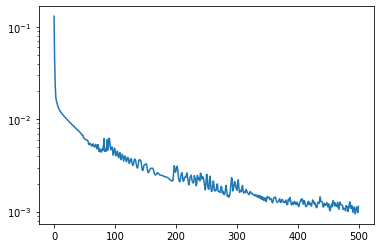

In [677]:
plt.semilogy(history.history['loss'])

# Evaluate Model
To evaluate the model, we create a similar structure but with `seq_length=1` and `batch_size=1`. The weights are taken from the trained model. This model can be evaluated recursiveley (with a single sequence element as input) and keeps track of the hidden state itself.

In [678]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=True)
#model_simple.compile(loss='mse', optimizer='Adam')

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (1, 1, 30)                4080      
_________________________________________________________________
time_distributed_215 (TimeDi (1, 1, 30)                930       
_________________________________________________________________
time_distributed_216 (TimeDi (1, 1, 30)                930       
_________________________________________________________________
time_distributed_217 (TimeDi (1, 1, 30)                930       
_________________________________________________________________
time_distributed_218 (TimeDi (1, 1, 6)                 186       
Total params: 7,056
Trainable params: 7,056
Non-trainable params: 0
_________________________________________________________________


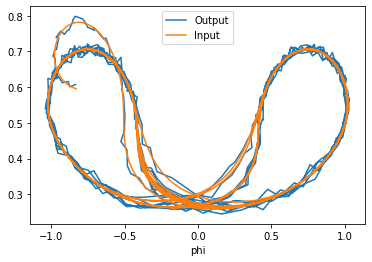

In [682]:
test_with = 2
nn_output_i = nn_output_test[test_with]
nn_input_i = nn_input_test[test_with]

fig,ax =plt.subplots()

nn_input_i.plot(x='phi', y='theta', label='Output', ax=ax)
nn_output_i.plot(x='phi', y='theta', label='Input', ax=ax)

In [683]:
model_simple.reset_states()
nn_input_i = nn_input_test[test_with]
nn_output_i = nn_output_test[test_with]


res = []

for i,in_i in nn_input_i.iterrows():
    rnn_in = in_i.to_numpy().reshape(1,-1)/x_scaling
    #rnn_in *= (1+0.1*np.random.randn(rnn_in.shape[0]))
    rnn_out = model_simple.predict(rnn_in.reshape(1,1,-1))*y_scaling
    res.append(rnn_out)
res = np.concatenate(res, axis=0).squeeze()
res_df = pd.DataFrame(res, columns = nn_output_i.keys())

Text(0, 0.5, 'v_0')

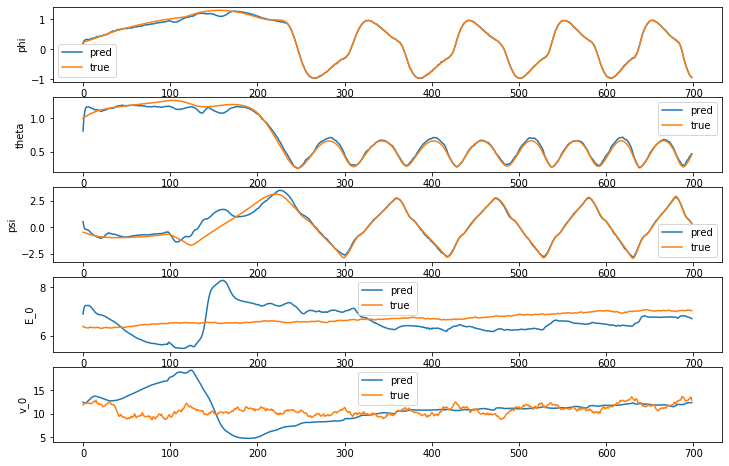

In [681]:
fig, ax = plt.subplots(5, figsize=(12,8))

res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
nn_output_i.plot(y=['phi'], ax=ax[0], label=['true'])
ax[0].set_ylabel('phi')

res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
nn_output_i.plot(y=['theta'], ax=ax[1], label=['true'])
ax[1].set_ylabel('theta')

res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
nn_output_i.plot(y=['psi'], ax=ax[2], label=['true'])
ax[2].set_ylabel('psi')

res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
nn_output_i.plot(y=['E_0'], ax=ax[3], label=['true'])
ax[3].set_ylabel('E_0')

res_df.plot(y=['v_0'], ax=ax[4], label=['pred'])
nn_output_i.plot(y=['v_0'], ax=ax[4], label=['true'])
ax[4].set_ylabel('v_0')

In [662]:
model_no = '009'

if True:
    model_simple.save_weights('./models/{model}_RNN/{model}_RNN_weights'.format(model=model_no))
    with open('./models/{model}_RNN/{model}_RNN_config.pkl'.format(model=model_no), 'wb') as f:
        pickle.dump({'model_param':model_param, 'y_scaling':y_scaling, 'x_scaling':x_scaling}, f)